In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:20,.2f}'.format

import acquire
import prepare
import model

### Acquisition and Prep

In [2]:
df = acquire.get_combined_store_data()
df = prepare.prep_store_data(df)

Reading from local CSV...
Reading from local CSV...
Reading from local CSV...


In [3]:
# identify target label
target = 'dollars_sold'
# get just the target variable
df = df[[target]]

In [4]:
df.head(3)

,dollars_sold
sale_date,
2013-01-01,"73,844.01"
2013-01-02,"73,570.58"
2013-01-03,"78,169.48"


### Train/Validate/Test Split

In [5]:
train, validate, test = prepare.train_validate_test_split(df)

### Resample

In [6]:
train = train.resample('W').sum()
validate = validate.resample('W').sum()
test = test.resample('W').sum()

### Modeling

In [7]:
model_number = 0
y_pred = pd.Series(index=validate.index)
model_info = pd.DataFrame()
model_results = pd.DataFrame()

#### Simple Average

In [8]:
model_number += 1
model_type = 'simple average'

# create predictions
y_pred = pd.Series(train[target].mean(), index=validate.index)

# store model info
dct = {'model_number': model_number,
       'RMSE': sqrt(mean_squared_error(validate[target], y_pred)),
       'model_type': model_type}
model_info = model_info.append(dct, ignore_index=True)


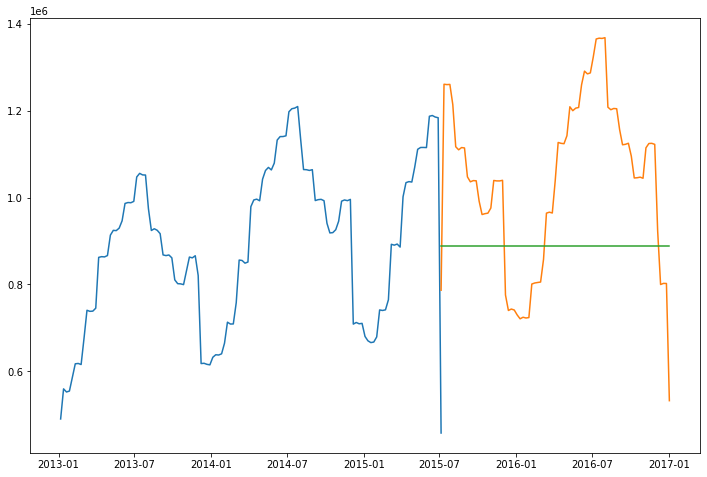

In [9]:
plt.figure(figsize=(12,8))
plt.plot(train[target])
plt.plot(validate[target])
plt.plot(y_pred)
plt.show()

#### Moving Average

In [10]:
model_type = 'moving average'
periods = [1, 2, 4, 8, 12]
units = 'wk'

for period in periods:
    model_number += 1
    
    # create predictions
    y_pred = pd.Series(train[target].rolling(period).mean().iloc[-1],
                       index=validate.index)
    
    # store model_info
    dct = {'model_number': model_number,
           'RMSE': sqrt(mean_squared_error(validate[target], y_pred)),
           'model_type': model_type,
           'period': f'{period}{units}'}
    model_info = model_info.append(dct, ignore_index=True)

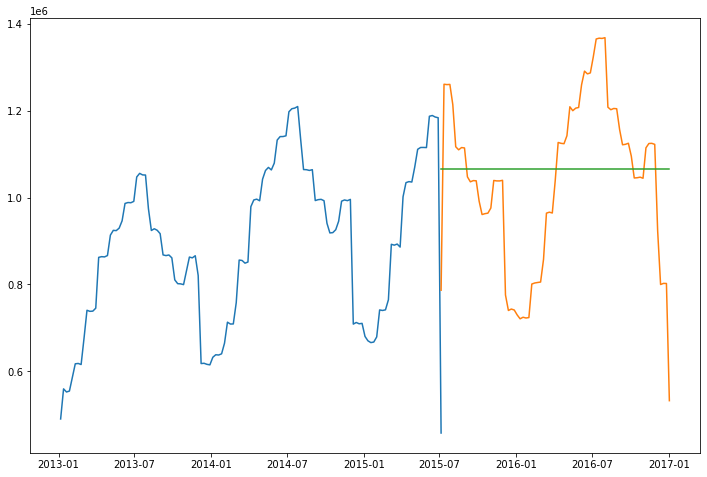

In [11]:
plt.figure(figsize=(12,8))
plt.plot(train[target])
plt.plot(validate[target])
plt.plot(y_pred)
plt.show()

#### Holt's Linear Trend

In [12]:
for smoothing_arg in np.arange(.1, 1.1, .1):
    model_number += 1
    model_type = 'holt'
    mdl = Holt(train[target])
    mdl = mdl.fit(smoothing_level=smoothing_arg,
                  smoothing_slope=smoothing_arg,
                  optimized=False)
    y_pred = pd.Series(mdl.predict(start=validate.index[0], 
                                     end=validate.index[-1]),
                       index=validate.index)
    # remove leap day
    y_pred = y_pred.drop([idx for idx in y_pred.index if (idx.month, idx.day) == (2, 29)])

    # store model info
    dct = {'model_number': model_number,
           'RMSE': sqrt(mean_squared_error(validate[target], y_pred)),
           'model_type': model_type,
           'smoothing_level': smoothing_arg,
           'smoothing_slope': smoothing_arg}
    model_info = model_info.append(dct, ignore_index=True)

In [13]:
model_info[model_info.model_type == 'holt'].drop(columns='period')

,model_number,RMSE,model_type,smoothing_level,smoothing_slope
6,7.00,"638,709.75",holt,0.10,0.10
7,8.00,"436,957.73",holt,0.20,0.20
8,9.00,"2,635,066.01",holt,0.30,0.30
9,10.00,"5,061,712.49",holt,0.40,0.40
10,11.00,"8,233,639.63",holt,0.50,0.50
11,12.00,"12,094,651.90",holt,0.60,0.60
12,13.00,"16,537,433.74",holt,0.70,0.70
13,14.00,"21,496,114.71",holt,0.80,0.80
14,15.00,"27,025,678.96",holt,0.90,0.90
15,16.00,"33,273,172.96",holt,1.00,1.00


#### Previous Cycle

In [14]:
#re-do splits to match annual cyles
train = df[:'2015'].resample('W').sum()
validate = df['2016'].resample('W').sum()
test = df['2017'].resample('W').sum()

In [15]:
train['2015'].index

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08', '2015-03-15', '2015-03-22',
               '2015-03-29', '2015-04-05', '2015-04-12', '2015-04-19',
               '2015-04-26', '2015-05-03', '2015-05-10', '2015-05-17',
               '2015-05-24', '2015-05-31', '2015-06-07', '2015-06-14',
               '2015-06-21', '2015-06-28', '2015-07-05', '2015-07-12',
               '2015-07-19', '2015-07-26', '2015-08-02', '2015-08-09',
               '2015-08-16', '2015-08-23', '2015-08-30', '2015-09-06',
               '2015-09-13', '2015-09-20', '2015-09-27', '2015-10-04',
               '2015-10-11', '2015-10-18', '2015-10-25', '2015-11-01',
               '2015-11-08', '2015-11-15', '2015-11-22', '2015-11-29',
               '2015-12-06', '2015-12-13', '2015-12-20', '2015-12-27'],
              dtype='datetime64[ns]', name='sale_date', freq='W-SUN')

In [16]:
validate.index

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28', '2016-03-06', '2016-03-13', '2016-03-20',
               '2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17',
               '2016-04-24', '2016-05-01', '2016-05-08', '2016-05-15',
               '2016-05-22', '2016-05-29', '2016-06-05', '2016-06-12',
               '2016-06-19', '2016-06-26', '2016-07-03', '2016-07-10',
               '2016-07-17', '2016-07-24', '2016-07-31', '2016-08-07',
               '2016-08-14', '2016-08-21', '2016-08-28', '2016-09-04',
               '2016-09-11', '2016-09-18', '2016-09-25', '2016-10-02',
               '2016-10-09', '2016-10-16', '2016-10-23', '2016-10-30',
               '2016-11-06', '2016-11-13', '2016-11-20', '2016-11-27',
               '2016-12-04', '2016-12-11', '2016-12-18', '2016-12-25',
               '2017-01-01'],
              dtype='datetime64[ns]', name='sal

In [17]:
model_number += 1
model_type = 'previous cycle'

# compute the average weekly delta year-over-year and add to the last annual cycle's values
y_pred = train['2015'] + train.diff(52).mean()
# set the index (drop one week from validate to account for different number of weeks in the year)
y_pred.index = validate[validate.index.week < 53].index

# store model info
dct = {'model_number': model_number,
       'RMSE': sqrt(mean_squared_error(validate[target][validate.index.week < 53], y_pred)),
       'model_type': model_type,
       'cycle_length': 'annual'}
model_info = model_info.append(dct, ignore_index=True)

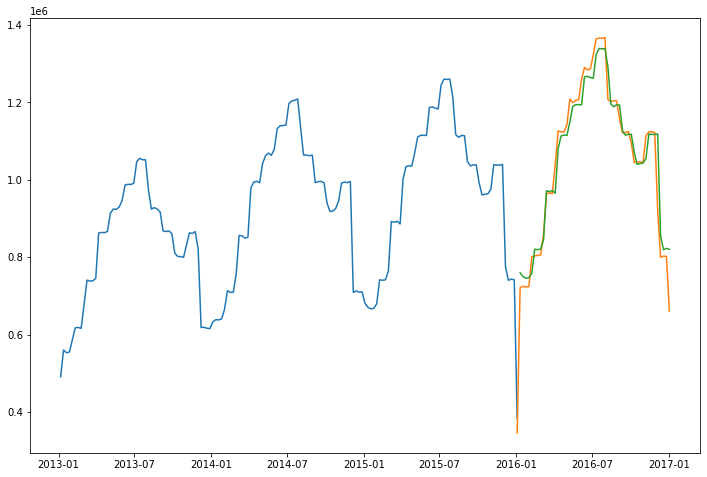

In [18]:
plt.figure(figsize=(12,8))
plt.plot(train[target])
plt.plot(validate[target])
plt.plot(y_pred)
plt.show()

### Evaluate
Which model performed best?

In [19]:
model_info[model_info.RMSE == model_info.RMSE.min()]

,model_number,RMSE,model_type,period,smoothing_level,smoothing_slope,cycle_length
16,17.00,"46,609.57",previous cycle,NaN,NaN,NaN,annual


#### make predictions for the test sample

In [32]:
# make predictions
y_pred = validate + train.diff(52).mean()
# reset index to match test sample
y_pred.index = test.index
# get the RMSE
RMSE = sqrt(mean_squared_error(test[target], y_pred))
f'Model #17 RMSE on test = {RMSE:,.2f}'

'Model #17 RMSE on test = 57,828.56'